In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from google.colab import drive 
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'seaborn'

In [9]:
data = pd.read_csv('gdrive/My Drive/Genius Sport test/tennis_match_data.csv')
data.head()

,FixtureId,Competitor1CurrentGameScorePoints,Competitor1CurrentSetScore,Competitor1MatchScore,Competitor2CurrentGameScorePoints,Competitor2CurrentSetScore,Competitor2MatchScore,Serving,StateOfPlay
0,3221713,0,0,0,0,0,0,2,PointInProgress
1,3221713,0,0,0,1,0,0,2,BetweenPoints
2,3221713,0,0,0,2,0,0,2,BetweenPoints
3,3221713,1,0,0,2,0,0,2,BetweenPoints
4,3221713,1,0,0,3,0,0,2,BetweenPoints


# Data	exploration

* How	many	data	points	(rows	or	independent	scoring	labels)	do	you	have	for	each	
fixture?	Does	this	mean	that	each	fixture	has	a	complete	record	of	all	possible
scores?

mean: 136


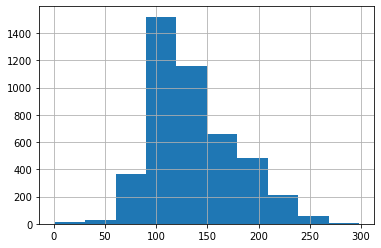

In [10]:
temp=data.groupby('FixtureId')['FixtureId'].count()
print('mean: {}'.format(round(temp.mean())))
temp.hist()

* What	is	the	size	of	the	data	set?	How	many	total	fixtures	are	there?

In [11]:
print('Number of fixtures: {}'.format(data.FixtureId.nunique()))
print('Total numbers of rows or data points: {}'.format(data.FixtureId.count()))

Number of fixtures: 4497
Total numbers of rows or data points: 610381


* Does	each	fixtureId	have	a	match	winner?

In [12]:
temp=data[data['StateOfPlay'].isin(['WinnerCompetitorOne','WinnerCompetitorTwo'])][['FixtureId','StateOfPlay']].reset_index(drop=True)
print('Number of FixtureId that have a winner: {}'.format(temp.FixtureId.nunique()))
print('Total numer of FixtureId: {}'.format(data.FixtureId.nunique()))

Number of FixtureId that have a winner: 4497
Total numer of FixtureId: 4497


* Have	a look	at	the	StateOfPlay	column.	What	are	the	possible	values	in this	
column?

In [13]:
list_=data['StateOfPlay'].unique()

print('StateOfPlay column values: \n')
for i in list_:
  print(i) 

StateOfPlay column values: 

PointInProgress
BetweenPoints
WinnerCompetitorTwo
WinnerCompetitorOne
ShortDelay
PlaySuspended
Challenge
MedicalTimeoutCompetitorTwo
MedicalTimeoutCompetitorOne


*  What	effect	might	a	‘MedicalTimeoutCompetitorOne[Two]’	have	on	the	
model?

In [16]:
temp=data[data['StateOfPlay'].isin(['WinnerCompetitorOne','WinnerCompetitorTwo'])][['FixtureId','StateOfPlay']]
temp.set_index('FixtureId',inplace=True)
winners_dict=temp.to_dict()['StateOfPlay']
# Add a column that indicates the match winner
data['Winner'] = data['FixtureId'].apply(lambda x: winners_dict[x])
temp_2=data[data['StateOfPlay'].isin(['MedicalTimeoutCompetitorOne','MedicalTimeoutCompetitorTwo'])][['FixtureId','StateOfPlay','Winner']]
temp_2

,FixtureId,StateOfPlay,Winner
69302,3940718,MedicalTimeoutCompetitorTwo,WinnerCompetitorOne
122666,3962341,MedicalTimeoutCompetitorTwo,WinnerCompetitorTwo
542453,4249614,MedicalTimeoutCompetitorOne,WinnerCompetitorOne
543637,4249628,MedicalTimeoutCompetitorOne,WinnerCompetitorTwo
604486,4272686,MedicalTimeoutCompetitorTwo,WinnerCompetitorOne


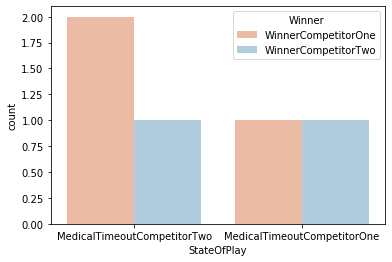

In [17]:
ax = sns.countplot(x="StateOfPlay", data=temp_2, hue='Winner', palette="RdBu",dodge=True)

The probability of winning the match after requesting medical attention is a bit low (With the small amount of samples we have,we could say that is about 40 %)

* Number of sets per game

# Data preprocessing

* Add a column with the current set

In [0]:
data['CurrentSet']=data['Competitor1MatchScore']+data['Competitor2MatchScore']+1

* Number of sets per game

In [20]:
data.groupby('FixtureId')['CurrentSet'].max().max()-1

3

* Add a column with the current game

In [0]:
data['CurrentGame']=data['Competitor1CurrentSetScore']+data['Competitor2CurrentSetScore']+1

In [0]:
#data.head()

* Add a column that indicates who won the first set



In [0]:
# Get a dictionary {FixtureId:Who won the first set}
temp=data[data['CurrentSet']==2][['FixtureId','Competitor1MatchScore']]
temp=temp.groupby(['FixtureId']).max()
temp['FirstSetWinner'] = temp['Competitor1MatchScore'].apply(lambda x : 'Competitor1' if x==1 else 'Competitor2')
set_winner_dict=temp.to_dict()['FirstSetWinner']
# Add a column to the data set with that information
data['FirstSetWinner'] = np.nan
data['FirstSetWinner']=data['FixtureId'].apply(lambda x : set_winner_dict[x] if x in set_winner_dict else 'N/A')
data.loc[data[data["CurrentSet"]==1].index.values, "FirstSetWinner"] = 'N/A'

In [26]:
data['FirstSetWinner'].unique()

array(['N/A', 'Competitor1', 'Competitor2'], dtype=object)

In [115]:
data.head()

,FixtureId,Competitor1CurrentGameScorePoints,Competitor1CurrentSetScore,Competitor1MatchScore,Competitor2CurrentGameScorePoints,Competitor2CurrentSetScore,Competitor2MatchScore,Serving,StateOfPlay,Winner,CurrentSet,CurrentGame,FirstSetWinner
0,3221713,0,0,0,0,0,0,2,PointInProgress,WinnerCompetitorTwo,1,1,N/A
1,3221713,0,0,0,1,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A
2,3221713,0,0,0,2,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A
3,3221713,1,0,0,2,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A
4,3221713,1,0,0,3,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A


* Add a column that indicates who won each game and the win rate of each player

In [0]:

lista=[]
l=len(data)
for i in range(l):
  if data.iloc[i,8] in ['WinnerCompetitorTwo','WinnerCompetitorOne']:
    lista.append(np.nan)
  elif (data.iloc[i+1,1] - data.iloc[i,1] ) == 1:
    lista.append('Competitor1')
  else:
    lista.append('Competitor2')

In [0]:
data['GameWinner'] = lista

In [29]:
data.head()

,FixtureId,Competitor1CurrentGameScorePoints,Competitor1CurrentSetScore,Competitor1MatchScore,Competitor2CurrentGameScorePoints,Competitor2CurrentSetScore,Competitor2MatchScore,Serving,StateOfPlay,Winner,CurrentSet,CurrentGame,FirstSetWinner,GameWinner
0,3221713,0,0,0,0,0,0,2,PointInProgress,WinnerCompetitorTwo,1,1,N/A,Competitor2
1,3221713,0,0,0,1,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A,Competitor2
2,3221713,0,0,0,2,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A,Competitor1
3,3221713,1,0,0,2,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A,Competitor2
4,3221713,1,0,0,3,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A,Competitor1


* Add a column that indicates the how many points have been played in each match

In [0]:
l=data['FixtureId'].unique()
#data['GameNumber']=np.nan
lista=[]
for i in l:
  temp = data[data['FixtureId']==i]
  cont=0
  for i in range(len(temp)):
    cont+=1
    lista.append(cont)


In [0]:
data['GameNumber']=lista


* Win points rate of each playes

In [0]:
l=data['FixtureId'].unique()
lista1=[]
lista2=[]
for i in l:
  temp = data[data['FixtureId']==i]
  #first_index=temp.index.values[0]
  for i in range(len(temp)):
    
    win_percentage= sum(temp.iloc[0:i+1,:]['GameWinner']=='Competitor1')/(i+1)
    lista1.append(win_percentage)
    lista2.append(1-win_percentage)

In [0]:
data['PointsWonCompetitor1']=lista1
data['PointsWonCompetitor2']=lista2


In [34]:
data.head()

,FixtureId,Competitor1CurrentGameScorePoints,Competitor1CurrentSetScore,Competitor1MatchScore,Competitor2CurrentGameScorePoints,Competitor2CurrentSetScore,Competitor2MatchScore,Serving,StateOfPlay,Winner,CurrentSet,CurrentGame,FirstSetWinner,GameWinner,GameNumber,PointsWonCompetitor1,PointsWonCompetitor2
0,3221713,0,0,0,0,0,0,2,PointInProgress,WinnerCompetitorTwo,1,1,N/A,Competitor2,1,0.000000,1.000000
1,3221713,0,0,0,1,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A,Competitor2,2,0.000000,1.000000
2,3221713,0,0,0,2,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A,Competitor1,3,0.333333,0.666667
3,3221713,1,0,0,2,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A,Competitor2,4,0.250000,0.750000
4,3221713,1,0,0,3,0,0,2,BetweenPoints,WinnerCompetitorTwo,1,1,N/A,Competitor1,5,0.400000,0.600000


* Drop rows that indicate the final score

In [0]:
data.drop(data[data['StateOfPlay'].isin(['WinnerCompetitorOne','WinnerCompetitorTwo'])].index.values,inplace=True)

* Drop the columns that dont give information to the prediction

In [0]:
data.drop(['FixtureId','Competitor1CurrentGameScorePoints','Competitor2CurrentGameScorePoints','Serving','StateOfPlay','GameWinner'], axis=1,inplace=True)

In [0]:
#data.drop(['GameWinner'],axis=1,inplace=True)

In [0]:
data.to_csv('gdrive/My Drive/Genius Sport test/data.csv')

* Visualize de data

In [0]:
data.reset_index(drop=True,inplace=True)

* Create a One Hot Encoded Data 

In [0]:
from sklearn.preprocessing import OneHotEncoder

In [0]:
categorical_columns=['Winner','FirstSetWinner']

In [0]:
# Instanciar el encoder
encoder = OneHotEncoder(drop='first')

# Entrenar el encoder
#encoder.fit(train_data[columns])

def one_hot(data, encoder, categorical_columns):
    encoder.fit(data[categorical_columns])

    # Generar los valores binarios
    valores = encoder.transform(data[categorical_columns]).toarray()

    #Construír un DataFrame a partir de estos valores para después concatenarlo al original
    encoded_df = pd.DataFrame(valores ,columns=[encoder.get_feature_names()])

    # Eliminar columanas con variables categóricas 
    temp=data.drop(columns=categorical_columns)

    # Concatenar los DataFrames
    data = pd.concat([temp,encoded_df], axis=1)
    
    return data

data_encoded = one_hot(data, encoder, categorical_columns)

In [43]:
data_encoded.head()

,Competitor1CurrentSetScore,Competitor1MatchScore,Competitor2CurrentSetScore,Competitor2MatchScore,CurrentSet,CurrentGame,GameNumber,PointsWonCompetitor1,PointsWonCompetitor2,"(x0_WinnerCompetitorTwo,)","(x1_Competitor2,)","(x1_N/A,)"
0,0,0,0,0,1,1,1,0.000000,1.000000,1.0,0.0,1.0
1,0,0,0,0,1,1,2,0.000000,1.000000,1.0,0.0,1.0
2,0,0,0,0,1,1,3,0.333333,0.666667,1.0,0.0,1.0
3,0,0,0,0,1,1,4,0.250000,0.750000,1.0,0.0,1.0
4,0,0,0,0,1,1,5,0.400000,0.600000,1.0,0.0,1.0


* Scale the data

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler=StandardScaler()

In [46]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605881 entries, 0 to 605880
Data columns (total 12 columns):
Competitor1CurrentSetScore    605881 non-null int64
Competitor1MatchScore         605881 non-null int64
Competitor2CurrentSetScore    605881 non-null int64
Competitor2MatchScore         605881 non-null int64
CurrentSet                    605881 non-null int64
CurrentGame                   605881 non-null int64
GameNumber                    605881 non-null int64
PointsWonCompetitor1          605881 non-null float64
PointsWonCompetitor2          605881 non-null float64
(x0_WinnerCompetitorTwo,)     605881 non-null float64
(x1_Competitor2,)             605881 non-null float64
(x1_N/A,)                     605881 non-null float64
dtypes: float64(5), int64(7)
memory usage: 55.5 MB


In [0]:
scaler = StandardScaler()

def data_scaler(data, scaler,columns):
    """
    data: DataFrame que contiene los datos
    scaler: escalador (objeto de la clase sklearn.preprocessing.StandardScaler)
    
    return : DataFrame con las columnas que son de tipo numérico (int64) escaladas 
    """
    
    data[columns] = scaler.fit_transform(data[columns])
    
    return data

In [0]:
columns=['GameNumber','PointsWonCompetitor1','PointsWonCompetitor2','CurrentGame','CurrentSet','Competitor1MatchScore','Competitor2MatchScore','Competitor2CurrentSetScore','Competitor1CurrentSetScore']
data_encoded = data_scaler(data_encoded,scaler,columns)

In [49]:
data_encoded.head()

,Competitor1CurrentSetScore,Competitor1MatchScore,Competitor2CurrentSetScore,Competitor2MatchScore,CurrentSet,CurrentGame,GameNumber,PointsWonCompetitor1,PointsWonCompetitor2,"(x0_WinnerCompetitorTwo,)","(x1_Competitor2,)","(x1_N/A,)"
0,-1.288005,-0.731742,-1.278678,-0.711404,-1.006476,-1.436702,-1.482417,-4.808393,4.808393,1.0,0.0,1.0
1,-1.288005,-0.731742,-1.278678,-0.711404,-1.006476,-1.436702,-1.462145,-4.808393,4.808393,1.0,0.0,1.0
2,-1.288005,-0.731742,-1.278678,-0.711404,-1.006476,-1.436702,-1.441873,-1.058300,1.058300,1.0,0.0,1.0
3,-1.288005,-0.731742,-1.278678,-0.711404,-1.006476,-1.436702,-1.421602,-1.995823,1.995823,1.0,0.0,1.0
4,-1.288005,-0.731742,-1.278678,-0.711404,-1.006476,-1.436702,-1.401330,-0.308281,0.308281,1.0,0.0,1.0


In [50]:
data.head()

,Competitor1CurrentSetScore,Competitor1MatchScore,Competitor2CurrentSetScore,Competitor2MatchScore,Winner,CurrentSet,CurrentGame,FirstSetWinner,GameNumber,PointsWonCompetitor1,PointsWonCompetitor2
0,0,0,0,0,WinnerCompetitorTwo,1,1,N/A,1,0.000000,1.000000
1,0,0,0,0,WinnerCompetitorTwo,1,1,N/A,2,0.000000,1.000000
2,0,0,0,0,WinnerCompetitorTwo,1,1,N/A,3,0.333333,0.666667
3,0,0,0,0,WinnerCompetitorTwo,1,1,N/A,4,0.250000,0.750000
4,0,0,0,0,WinnerCompetitorTwo,1,1,N/A,5,0.400000,0.600000


# Trainning

In [0]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


* Split the data

In [2]:
X=data.drop('Winner',axis=1)
y=data['Winner']

NameError: ignored

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data with One Hot Encoding

In [0]:
X_one=data_encoded.drop(('x0_WinnerCompetitorTwo',),axis=1)

In [0]:
y_one= data_encoded[('x0_WinnerCompetitorTwo',)]

In [0]:
X_train_one, X_test_one, y_train_one, y_test_one = train_test_split(X_one, y_one, test_size=0.2, random_state=41)

* Test some models 

lgb -  Dropouts meet Multiple Additive Regression Trees

In [0]:
lgb_train = lgb.Dataset(X_train_one, y_train_one)
lgb_eval = lgb.Dataset(X_test_one, y_test_one, reference=lgb_train)

In [147]:
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': {'l2', 'l1'},
    'num_leaves': 100000,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5,)


Starting training...
[1]	valid_0's l1: 0.490862	valid_0's l2: 0.24138


/usr/local/lib/python3.6/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's l1: 0.482672	valid_0's l2: 0.233822
[3]	valid_0's l1: 0.47524	valid_0's l2: 0.227307
[4]	valid_0's l1: 0.467815	valid_0's l2: 0.221135
[5]	valid_0's l1: 0.460765	valid_0's l2: 0.21559
[6]	valid_0's l1: 0.454394	valid_0's l2: 0.210815
[7]	valid_0's l1: 0.448347	valid_0's l2: 0.206521
[8]	valid_0's l1: 0.450803	valid_0's l2: 0.208226
[9]	valid_0's l1: 0.445065	valid_0's l2: 0.204228
[10]	valid_0's l1: 0.439482	valid_0's l2: 0.200585
[11]	valid_0's l1: 0.43418	valid_0's l2: 0.197296
[12]	valid_0's l1: 0.436302	valid_0's l2: 0.198605
[13]	valid_0's l1: 0.430853	valid_0's l2: 0.195274
[14]	valid_0's l1: 0.425974	valid_0's l2: 0.192509
[15]	valid_0's l1: 0.421334	valid_0's l2: 0.190025
[16]	valid_0's l1: 0.416932	valid_0's l2: 0.187783
[17]	valid_0's l1: 0.412422	valid_0's l2: 0.185509
[18]	valid_0's l1: 0.408179	valid_0's l2: 0.183502
[19]	valid_0's l1: 0.404184	valid_0's l2: 0.181723
[20]	valid_0's l1: 0.400363	valid_0's l2: 0.180119


In [0]:
y_train_pred=gbm.predict(X_train_one)
y_test_pred=gbm.predict(X_test_one)

In [0]:
y_train_pred_=[]
for i in y_train_pred:
  if i > 0.5:
    y_train_pred_.append(1)
  else:
    y_train_pred_.append(0)

y_test_pred_=[]
for i in y_test_pred:
  if i > 0.5:
    y_test_pred_.append(1)
  else:
    y_test_pred_.append(0)

In [150]:
GBM_test_error = accuracy_score(y_test_one, y_test_pred_)
print('Trian accuracy: {}'.format(accuracy_score(y_train_one, y_train_pred_)))
print('Test accuracy: {}'.format(GBM_test_error))

Trian accuracy: 0.7620754109724698
Test accuracy: 0.7460821773108758


Random Forest

In [151]:
RandomForest = RandomForestClassifier(n_estimators=300)
RandomForest.fit(X_train_one,y_train_one)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_train_pred=RandomForest.predict(X_train_one)
y_test_pred=RandomForest.predict(X_test_one)


In [153]:
RF_test_error = accuracy_score(y_test_one, y_test_pred)
print('Trian accuracy: {}'.format(accuracy_score(y_train_one, y_train_pred)))
print('Test accuracy: {}'.format(RF_test_error))

Trian accuracy: 0.7834038918597742
Test accuracy: 0.734008929087203


LogisticRegression

In [0]:
from sklearn.preprocessing import PolynomialFeatures

In [0]:
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train_one)
X_test_poly = poly.fit_transform(X_test_one)

In [0]:
LR=LogisticRegression(C=100,max_iter=1000)

In [157]:
LR.fit(X_train_poly,y_train_one)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_train_pred=LR.predict(X_train_poly)
y_test_pred=LR.predict(X_test_poly)

In [159]:
LR_test_error = accuracy_score(y_test_one, y_test_pred)
print('Trian accuracy: {}'.format(accuracy_score(y_train_one, y_train_pred)))
print('Test accuracy: {}'.format(LR_test_error))

Trian accuracy: 0.7433278867102396
Test accuracy: 0.7452569381978428


SVC

In [0]:
SVC_model = SVC(max_iter=1000,C=100,gamma='auto')

In [161]:
SVC_model.fit(X_train_one,y_train_one)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_train_pred=SVC_model.predict(X_train_one)
y_test_pred=SVC_model.predict(X_test_one)

In [163]:
SVC_test_error = accuracy_score(y_test_one, y_test_pred)
print('Trian accuracy: {}'.format(accuracy_score(y_train_one, y_train_pred)))
print('Test accuracy: {}'.format(SVC_test_error))

Trian accuracy: 0.5210169505512643
Test accuracy: 0.5218317007352881


Gradient Boosting

In [0]:
GB = GradientBoostingClassifier(learning_rate=1)

In [165]:
GB.fit(X_train_one,y_train_one)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
y_train_pred=GB.predict(X_train_one)
y_test_pred=GB.predict(X_test_one)

In [167]:
GB_test_error = accuracy_score(y_test_one, y_test_pred)
print('Trian accuracy: {}'.format(accuracy_score(y_train_one, y_train_pred)))
print('Test accuracy: {}'.format(GB_test_error))

Trian accuracy: 0.745444642503466
Test accuracy: 0.74568606253662


* Comparison

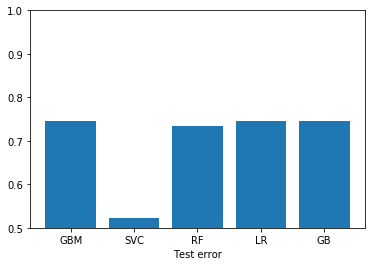

<Figure size 2160x720 with 0 Axes>

In [168]:
import matplotlib.pyplot as plt
 
height = [GBM_test_error, SVC_test_error, RF_test_error, LR_test_error, GB_test_error]
bars = ('GBM', 'SVC', 'RF', 'LR', 'GB')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)

plt.xticks(y_pos, bars )
plt.xlabel('Test error')
plt.ylim(0.5,1)

plt.figure(figsize=(30,10))
plt.show()


* Inference Time

In [169]:
# binomial confidence interval for the inference time
from math import sqrt
# Number of samples
GameNumber =40
#Classification error
cls_error=0.2
interval = 1.96 * sqrt( (cls_error * (1 - cls_error)) /GameNumber)
print('%.3f' % interval)


0.124


* When my model will performe better

In [0]:
sample=data[data['GameNumber']<50].reset_index(drop=True)

In [0]:
sample = one_hot(sample, encoder, categorical_columns)

In [0]:
columns=['GameNumber','PointsWonCompetitor1','PointsWonCompetitor2','CurrentGame','CurrentSet','Competitor1MatchScore','Competitor2MatchScore','Competitor2CurrentSetScore','Competitor1CurrentSetScore']
sample = data_scaler(sample,scaler,columns)

In [0]:
X_sample=sample.drop(('x0_WinnerCompetitorTwo',),axis=1)
y_sample=sample[('x0_WinnerCompetitorTwo',)]

In [0]:
y_sample_pred=GB.predict(X_sample)

In [175]:
accuracy_score(y_sample, y_sample_pred)

0.6301860710453082

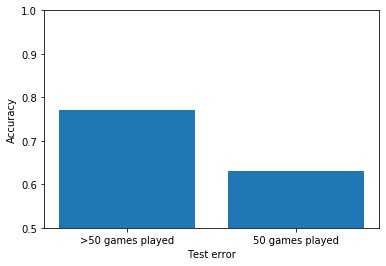

<Figure size 2160x720 with 0 Axes>

In [176]:
height = [0.77, 0.63]
bars = ('>50 games played', '50 games played')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)

plt.xticks(y_pos, bars )
plt.xlabel('Test error')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)

plt.figure(figsize=(30,10))
plt.show()

* Try with a Neural Network

In [0]:
import tensorflow as tf

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_one.values, y_train_one.values))

In [0]:
train_dataset = dataset.shuffle(len(X_train_one)).batch(100)

In [0]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [181]:
model = get_compiled_model()
model.fit(train_dataset, epochs=15)

Train on 4848 steps
Epoch 1/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5113 - acc: 0.7379
Epoch 2/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5045 - acc: 0.7416
Epoch 3/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5036 - acc: 0.7418
Epoch 4/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5031 - acc: 0.7416
Epoch 5/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5027 - acc: 0.7419
Epoch 6/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5024 - acc: 0.7420
Epoch 7/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5020 - acc: 0.7423
Epoch 8/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5016 - acc: 0.7427
Epoch 9/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5014 - acc: 0.7425
Epoch 10/15
4848/4848 [==============================] - 9s 2ms/step - loss: 0.5012 - acc: 0.7424
Epoch 11/